<div style="background-color: #1f5c33; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">Handwritten Digit Recognition</h1>
  <p style="margin: 10px 0; font-size: 18px; font-style: italic; text-align: center;">Building a Neural Network from Scratch.</p>
</div>


<!-- This is your first markdown cell -->

<div style="margin-bottom: 35px;"></div>

<!-- This is your second markdown cell -->


In [36]:
# IMPORTING PACKAGES

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math

In [37]:
# Load training and testing data

train = pd.read_csv("/Users/akshay/projects/nn_from_scratch/digit-recognizer/train.csv")
test = pd.read_csv("/Users/akshay/projects/nn_from_scratch/digit-recognizer/test.csv")

print("train.shape:" + str(train.shape))
print("test.shape:" + str(test.shape))

train.shape:(42000, 785)
test.shape:(28000, 784)


In [38]:
def convert_data_to_arrays(train, test):
    
    # the x values start at the second column
    train_x = np.array(train.iloc[:,1:].values)
    
    # they y value is the label, it starts at the first column
    train_y = np.array(train.iloc[:,0].values)
    
    # the test data does not have the label
    test_x = test.iloc[:,:].values
    
    # generate the test_y return value and initialize with zeros
    test_y = np.zeros((test_x.shape[0], 1))
    
    
    ### NOTE:~ the above arrays are being transposed... from a row vector to column vector
    train_x = train_x.T
    train_y = train_y.T
    test_x = test_x.T
    test_y = test_y.T

    ### NOTE:~ train_y is currently a 1d array, needs to be reshaped to 2d
    train_y = np.reshape(train_y, (1, -1))

    return train_x, train_y, test_x, test_y

In [39]:

# the returned values above are dataframes

print("train.shape:" + str(train.shape))
print("test.shape:" + str(test.shape))

orig_train_x, orig_train_y, orig_test_x, orig_test_y = convert_data_to_arrays(train, test)
    
print("orig_train_x.shape:" + str(orig_train_x.shape))
print("orig_train_y.shape:" + str(orig_train_y.shape))
print("orig_test_x.shape:" + str(orig_test_x.shape))
print("orig_test_y.shape:" + str(orig_test_y.shape))

train.shape:(42000, 785)
test.shape:(28000, 784)
orig_train_x.shape:(784, 42000)
orig_train_y.shape:(1, 42000)
orig_test_x.shape:(784, 28000)
orig_test_y.shape:(1, 28000)


In [60]:
### This function creates indices for splitting labeled data. Indices are randomized
def split_labeled_idx(data, pct_train=0.6, pct_valid=0.2):
    # We need to split data into train/valid/test sets

    # figure out the number of train and valid cases
    num_split_train = int(pct_train*data.shape[1])
    num_split_valid = int(pct_valid*data.shape[1])

    # shuffle the indices before splitting
    shuffle_idx = np.random.permutation(data.shape[1])

    # figure out the indices for the train, valid and test sets
    split_train_idx = shuffle_idx[:num_split_train]
    split_valid_idx = shuffle_idx[num_split_train:num_split_train + num_split_valid]
    split_test_idx = shuffle_idx[num_split_train + num_split_valid:]
    
    return (split_train_idx, split_valid_idx, split_test_idx)

### This function uses the pre-calculated indices and splits the labeled data
def split_labeled_data(data, split_train_idx, split_valid_idx, split_test_idx):
    # split the data with the precalculated indices
    return data[:, split_train_idx], data[:, split_valid_idx], data[:, split_test_idx]

In [41]:
#Split the labeled data into train/valid/test sets


pct_split_train = 0.8 #  
pct_split_valid = 0.1 # => 0.1 is left for split_test

## get the indices
(split_train_idx, split_valid_idx, split_test_idx) = split_labeled_idx(orig_train_x, pct_split_train, pct_split_valid)

(split_train_x, split_valid_x, split_test_x) = split_labeled_data(orig_train_x, split_train_idx, split_valid_idx, split_test_idx)
(split_train_y, split_valid_y, split_test_y) = split_labeled_data(orig_train_y, split_train_idx, split_valid_idx, split_test_idx)

print("split_train_x.shape" + str(split_train_x.shape))
print("split_valid_x.shape" + str(split_valid_x.shape))
print("split_test_x.shape" + str(split_test_x.shape))
print("split_train_y.shape" + str(split_train_y.shape))
print("split_valid_y.shape" + str(split_valid_y.shape))
print("split_test_y.shape" + str(split_test_y.shape))

split_train_x.shape(784, 33600)
split_valid_x.shape(784, 4200)
split_test_x.shape(784, 4200)
split_train_y.shape(1, 33600)
split_valid_y.shape(1, 4200)
split_test_y.shape(1, 4200)


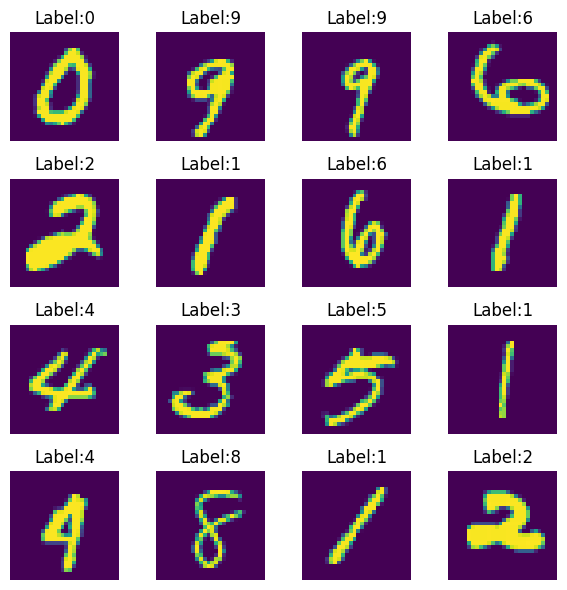

In [42]:
# pixels is an array that has columns for each image
# pixel_array contains the pixels to print it is [28*28, num_pics] in dimension
# num_rows and num_cols describes how many images to print and how to organize
# img_size is a tuple (28, 28) that provides image dimension
# This function handles the case where num_rows * num_cols < num_pics 
def print_images(pixel_array, img_size, num_rows, num_cols, label_array = None):
    fig_width = 6 # inches
    fig_height = 6# inches
    
    ## the above display well for a 3x3 matrix - let's try and scale this
    ratio = int(num_rows/num_cols)
    if ratio > 1:
        fig_height = int(fig_height*ratio)
    
    fig = plt.figure(figsize=(fig_width,fig_height))

    num_pics = pixel_array.shape[1]
    pic_idxs = np.arange(num_pics)

    # check if we have to sample a subset
    if num_rows*num_cols < num_pics:
        pic_idxs = np.random.choice(pic_idxs, num_rows*num_cols, replace=False)
    
    for i, pic_idx in enumerate(pic_idxs):
        # reshape the array into a 2d image
        tmp_img =pixel_array[:, pic_idx]
        tmp_img = np.reshape(tmp_img, img_size)
        # add a subplot to the figure at the right location in the grid
        tmp_sub = fig.add_subplot(num_rows, num_cols, i + 1)
        # NOTE:~ we did not have to scale the numbers, imshow does that
        # check for a label
        if label_array is not None:
            tmp_sub.set_title("Label:" + str(label_array[0, pic_idx]))
        tmp_img_plot = plt.imshow(tmp_img)
        plt.axis("off")

    fig.tight_layout()
    plt.show()
    
img_size = (28, 28)

print_images(orig_train_x, img_size, 4, 4, orig_train_y)

In [44]:
########## Initialization of parameters for a deep net 

def initialize_model_params(HYPER_layers, HYPER_W_factor, DEBUG_seed):
    parameters = {}
    L = len(HYPER_layers) # number of layers in the network

    for l in range(1, L):
        W_str = "W" + str(l)
        b_str = "b" + str(l)
        
        # set the seed if it is passed in
        if DEBUG_seed is not None:
            np.random.seed(DEBUG_seed+l)
            
        parameters[W_str] = np.random.randn(HYPER_layers[l], 
                                            HYPER_layers[l-1])*HYPER_W_factor 
        parameters[b_str] = np.zeros((HYPER_layers[l], 1))
        
        assert(parameters[W_str].shape == (HYPER_layers[l], HYPER_layers[l-1]))
        assert(parameters[b_str].shape == (HYPER_layers[l], 1))

    return parameters

In [45]:
########## create mini batches instead of going one example at a time
### NOTE:~ This assumes that the data in X and Y have already been shuffled
def create_mini_batches(X, Y, mini_batch_size):
    mini_batches = []
    
    num_batches = math.ceil(1.0*X.shape[1]/(mini_batch_size))
    
    mini_batches_x = np.array_split(X, num_batches, axis=1)
    mini_batches_y = np.array_split(Y, num_batches, axis=1)

    for min_x, min_y in zip(mini_batches_x, mini_batches_y):
        mini_batch = (min_x, min_y)
        mini_batches.append(mini_batch)

    return mini_batches

In [46]:
########## Forward propagataion for Sigmoid unit
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    assert(A.shape == Z.shape)
    return A

########## Forward propagataion for RELU unit
def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    return A

########## Forward propagataion for Softmax unit
### For softmax, Z will have as many nodes are in the last unit of the network 
### NOTE:~ the assumption here is that Z's shape is (num_vals x m)
### ie the training data is in columns
def softmax(Z):
    tmp = np.exp(Z)
    A = tmp/np.sum(tmp, axis=0)
    assert(A.shape == Z.shape)
    return A

In [47]:
### This function calculates Z from the previous activation and params
### This is the linear part of the forward pass for one layer
def calculate_Z(A_prev, W, b):
    Z = W.dot(A_prev) + b    
    assert(Z.shape == (W.shape[0], A_prev.shape[1]))
    return Z

### Calculates the activation from the previous activation and params
### This is the full forward pass for one layer
def calculate_A(Z, activation_type):
    if activation_type == "sigmoid":
        A = sigmoid(Z)
    
    elif activation_type == "relu":
        A = relu(Z)
    
    elif activation_type == "softmax":
        A = softmax(Z)
    
    assert (A.shape == Z.shape)
    return A

In [48]:
########## This is a generic way of moving forward for a deep network
### The assumption is that all units other than the output are RELU

def forward_pass(X, parameters, output_unit):
    cache = {}
    A = X
    L = len(parameters) // 2 # number of layers in the neural network
    cache["A0"] = X # initialize the cache with the input layer
    
    # go through all the layers of the unit
    for l in range(1, L+1):
        activation_type = "relu" # for all layers except the output unit
        if l == L:
            # this is the output unit
            activation_type = output_unit
            
        A_prev = A 
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        Z = calculate_Z(A_prev, W, b)
        A = calculate_A(Z, activation_type)
        # store the params and activations for backward prop
        cache["W" + str(l)] = W
        cache["b" + str(l)] = b
        cache["Z" + str(l)] = Z
        cache["A" + str(l)] = A
    
    return cache["A" + str(L)], cache

In [49]:
########## This computes the cost at the end of the foward propagation step
def compute_cost(AL, Y, output_unit):
    m = Y.shape[1] # the number of training examples

    #### The last unit is either a sigmoid of softmax
    if output_unit == "sigmoid":
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    elif output_unit == "softmax":
        # from the lecture notes, we are basically doing an elementwise multiply
        # of Y (zeros and ones) with AL (activations coming out of layer L
        # and then summing them all up and finally dividing by num training examples
        ### NOTE: tmpAL needed because AL was sometimes zero
        tmpAL = np.maximum(AL, 1.0e-15)  
        cost = (-1./m) * (np.sum(np.multiply(Y, np.log(tmpAL))) + np.sum(np.multiply(1-Y, np.log(1-tmpAL))))
    
    cost = np.squeeze(cost) # to change the shape of cost
    assert(cost.shape == ())

    return cost

In [50]:
########## Backward Propagataion for Sigmoid unit
def sigmoid_backward(dA, cache, layer):
    Z = cache["Z" + str(layer)]    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

########## Backward Propgataion for RELU unit
def relu_backward(dA, cache, layer):
    Z = cache["Z" + str(layer)]
    dZ = np.array(dA, copy=True) # creating a copy of dA    
    # When z <= 0, you should set dz to 0 as well 
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

########## Backward Propgataion for Softmax unit
def softmax_backward(dA, cache, layer):
    Z = cache["Z" + str(layer)]
    AL = cache["A" + str(layer)]
    Y = cache["Y"]
    ##### NOTE: for softmax we need AL and Y because per notes dZ = AL - Y
    dZ = AL - Y
    assert (dZ.shape == Z.shape)
    return dZ


In [51]:

########## Calculate partial derivatives for the current layer
def calculate_partial_derivatives(dA, cache, layer, activation_type):
    ### first calculate dZ based on activation type
    if activation_type == "relu":
        dZ = relu_backward(dA, cache, layer)
        
    elif activation_type == "sigmoid":
        dZ = sigmoid_backward(dA, cache, layer)
    
    elif activation_type == "softmax":
        dZ = softmax_backward(dA, cache, layer)
    
    ### with dZ calculate remaining derivatives
    A_prev = cache["A" + str(layer-1)]
    W = cache["W" + str(layer)]
    b = cache["b" + str(layer)]
    m = A_prev.shape[1]
    
    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

In [52]:
def backward_pass(L, cache, output_unit):
    grads = {} # value to be returned

    AL = cache["A" + str(L)]
    m = AL.shape[1]
    Y = cache["Y"]
    assert(Y.shape == AL.shape)
    
    # initialize backward propagation 
    ### NOTE:~ dAL is not used in the softmax case, only in sigmoid
    ### in the future find a way to abstract this out
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    grads["dA" + str(L)] = dAL

    # calculate the partial derivatives for all the layers
    for l in reversed(range(1, L+1)):
        activation_type = "relu" # for all layers except the output unit
        if l == L:
            # this is the output unit
            activation_type = output_unit
            
        dA_prev_temp, dW_temp, db_temp = calculate_partial_derivatives(grads["dA" + str(l)], cache, l, activation_type)
        grads["dA" + str(l-1)] = dA_prev_temp
        grads["dW" + str(l)] = dW_temp
        grads["db" + str(l)] = db_temp

    return grads

In [53]:
########## Update all the model parameters with the gradients
def update_model_params(params, grads, learning_rate):
    L = len(params) // 2 # number of layers in the neural network
    for l in range(1, L):
        W_str = "W" + str(l)
        b_str = "b" + str(l)
        dW_str = "dW" + str(l)
        db_str = "db" + str(l)
        
        params[W_str] = params[W_str] - learning_rate * grads[dW_str]
        params[b_str] = params[b_str] - learning_rate * grads[db_str]
        
    return params

In [54]:

########## Train the model with minibatches
### NOTE:~ We detect if the last layer is a softmax or a sigmoid
###        If the last layer is softmax, Y is assumed to be one hot
###
### HYPER_layers are the nodes in the layers of the network 
###        exampel: [input, h1, output] would be [784, 64, 10]
###        The last layer is the output layer a value > 1 means softmax vs sigmoid
###
### HYPER_learning_rage this is the learning rate. Use 0.0001 as the default.
###
### HYPER_num_epochs are the number of epoch iterations. 
###        Start with a small number like 100 and gradually increase to say 1500
###
### HYPER_minibatch_size is the mini batch size. Use 32 or 64 by default
###
### HYPER_W_factor is for scaling down initialized values of W
###        Use 0.01 by default
###
def train_model(X, 
                Y, 
                HYPER_layers, 
                HYPER_learning_rate, 
                HYPER_num_epochs, 
                HYPER_minibatch_size, 
                HYPER_W_factor,
                DEBUG_seed,
                DEBUG_print_cost):

    ### By default assume the output unit is a sigmoid, detect if it's softmax
    output_unit = "sigmoid" # by default this is the choice
    if HYPER_layers[-1] > 1:
        output_unit = "softmax" # we have a softmax unit as the output
    
    # initalize the parameters
    parameters = initialize_model_params(HYPER_layers, 
                                         HYPER_W_factor, 
                                         DEBUG_seed)
    L = len(parameters) // 2 # number of layers in the neural network
    
    ### loop through all the epochs
    num_minibatches = int(X.shape[1]/HYPER_minibatch_size)
    
    # variables used for printing
    epoch_graph_frequency = 10
    costs_size = int(HYPER_num_epochs/epoch_graph_frequency)
    costs = np.zeros(costs_size)
    
    for epoch in range(HYPER_num_epochs):
        epoch_cost = 0.
    
        minibatches = create_mini_batches(X, Y, HYPER_minibatch_size)
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            
            # Do the forward pass
            AL, cache = forward_pass(minibatch_X, parameters, output_unit)
            
            # Add Y to the cache - the current minibatch
            cache["Y"] = minibatch_Y
        
            # Compute the cost
            minibatch_cost = compute_cost(AL, minibatch_Y, output_unit)
    
            # Do the backward pass
            grads = backward_pass(L, cache, output_unit)
            
            # Update model parameters
            parameters = update_model_params(parameters, grads, HYPER_learning_rate)
        
            # Update the epoch_cost
            epoch_cost += minibatch_cost / num_minibatches
                
        # Print the cost every 100 epochs
        if DEBUG_print_cost and ((epoch == 0) or ((epoch+1) % 100 == 0)):
            print ("Cost after epoch %i: %f" %(epoch+1, epoch_cost))
        if DEBUG_print_cost and epoch % epoch_graph_frequency == 0:
            costs_idx = int(epoch/epoch_graph_frequency)
            costs[costs_idx] = epoch_cost
    
    if DEBUG_print_cost:
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.xlabel('Epochs (tens)')
        plt.title("Learning rate =" + str(HYPER_learning_rate))
        plt.show()
    
    return parameters



In [55]:
########## This function predicts values for the final model
def predict(X, parameters, output_unit):
    # go through the forward pass once to get the output
    probas, cache = forward_pass(X, parameters, output_unit)

    p = None;
    
    if output_unit == "sigmoid":
        # convert probas to 0/1 predictions
        # shape should be 1,m
        p = (probas > 0.5).astype(int)
        
    elif output_unit == "softmax":
        p = np.zeros(probas.shape)
        # get the indexes of the max values in all columns
        tmp_prd_idx = np.argmax(probas, axis = 0)
        p[tmp_prd_idx, np.arange(len(tmp_prd_idx))] = 1

    return p

In [56]:
########## This function predicts values for the final model, but needs Y
###        since it reports accuracy of the model
def predict_accuracy(X, Y, parameters, output_unit):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = predict(X, parameters, output_unit)
    
    if output_unit == "sigmoid":
        print("Accuracy with Sigmoid: "  + str(np.sum((p == Y)/m)))
        
    elif output_unit == "softmax":
        tmp_p = p.astype(bool)
        tmp_y = Y.astype(bool)
        print("Accuracy with Softmax: " + str(np.sum((tmp_p & tmp_y)/m)))
    return p

In [57]:
### This function prints out the weights of a layer of a neural network as an image
### img_size provided as a tuple: (28, 28) for example
### num_rows and num_cols are the number of images to layout
### pixel_array is of dimension (num_pixels, num_images) - one column per image
def print_layer(pixel_array, img_size, num_rows, num_cols):
    fig_width = 6 # inches
    fig_height = 6 # inches
    
    ## the above display well for a 3x3 matrix - let's try and scale this
    ratio = int(num_rows/num_cols)
    if ratio > 1:
        fig_height = int(fig_height*ratio)
    
    fig = plt.figure(figsize=(fig_width, fig_height))

    num_pics = pixel_array.shape[1]
    pic_idxs = np.arange(num_pics)

    # check if we have to sample a subset
    if num_rows*num_cols < num_pics:
        pic_idxs = np.random.choice(pic_idxs, num_rows*num_cols, replace=False)
    
    for i, pic_idx in enumerate(pic_idxs):
        # reshape the array into a 2d image
        tmp_img =pixel_array[:, pic_idx]
        tmp_img = np.reshape(tmp_img, img_size)
        # add a subplot to the figure at the right location in the grid
        tmp_sub = fig.add_subplot(num_rows, num_cols, i + 1)
        # NOTE:~ we did not have to scale the numbers, imshow does that
        tmp_img_plot = plt.imshow(tmp_img)
        plt.axis("off")

    fig.tight_layout()
    plt.show()

In [58]:
### define the layers of the neural network
softmax_layers = [784, 64, 10]

### NOTE:~ the output layer has 10 nodes... this is a softmax unit

### we need to convert the *_y data sets to one-hot arrays
hot_split_train_y = convert_to_one_hot(split_train_y, 10)
hot_split_valid_y = convert_to_one_hot(split_valid_y, 10)
hot_split_test_y = convert_to_one_hot(split_test_y, 10)

print("hot_split_train_y:" + str(hot_split_train_y.shape))
print("hot_split_valid_y:" + str(hot_split_valid_y.shape))
print("hot_split_test_y:" + str(hot_split_test_y.shape))

hot_split_train_y:(10, 33600)
hot_split_valid_y:(10, 4200)
hot_split_test_y:(10, 4200)


Cost after epoch 1: 1.361468
Cost after epoch 100: 0.191456
Cost after epoch 200: 0.136199
Cost after epoch 300: 0.108610
Cost after epoch 400: 0.090929
Cost after epoch 500: 0.078414
Cost after epoch 600: 0.068951
Cost after epoch 700: 0.061482
Cost after epoch 800: 0.055384
Cost after epoch 900: 0.050312
Cost after epoch 1000: 0.046040


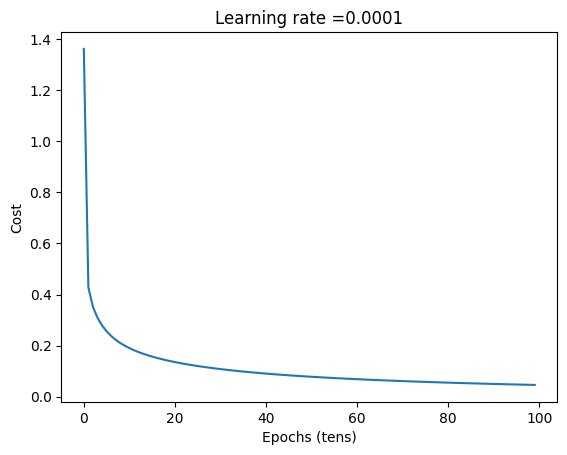

In [59]:
softmax_params = train_model(split_train_x, 
                             hot_split_train_y, 
                             HYPER_layers=softmax_layers, 
                             HYPER_learning_rate=0.0001, 
                             HYPER_num_epochs=1000, 
                             HYPER_minibatch_size=32,
                             HYPER_W_factor=0.01,
                             DEBUG_seed=1,
                             DEBUG_print_cost=True)

In [62]:
# get the predictions as an array
train_predict_probs = predict_accuracy(split_train_x, 
                                       hot_split_train_y, 
                                       softmax_params, 
                                       "softmax")

# generate labels from the predictions
train_predict_y = np.reshape(np.argmax(train_predict_probs, axis=0), (1, -1))

print("First ten original:" + str(split_train_y[0,0:20]))
print("First ten predicts:" + str(train_predict_y[0,0:20]))

Accuracy with Softmax: 0.9973511904761906
First ten original:[6 9 3 5 9 4 1 1 2 8 6 8 4 7 3 5 7 8 8 9]
First ten predicts:[6 9 3 5 9 4 1 1 2 8 6 8 4 7 3 5 7 8 8 9]


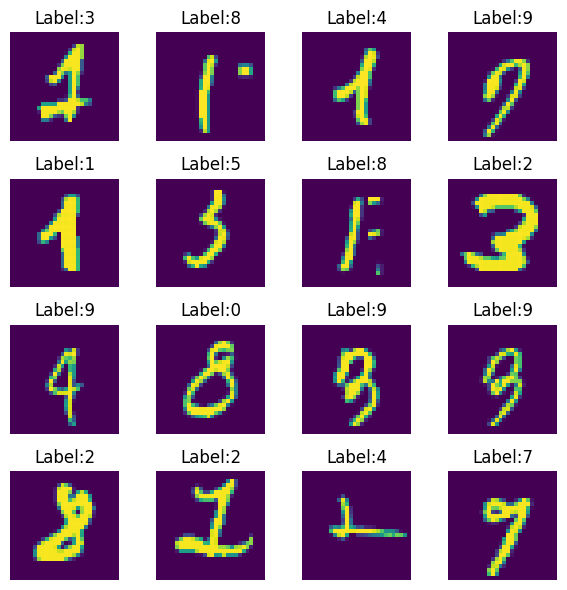

In [63]:
incorrect_idx = (train_predict_y != split_train_y)
incorrect_images = split_train_x[:,incorrect_idx[0,:]]
incorrect_labels = train_predict_y[:,incorrect_idx[0,:]]
print_images(incorrect_images, img_size, 4, 4, incorrect_labels)

In [64]:
# get the predictions as an array
valid_predict_probs = predict_accuracy(split_valid_x, 
                                       hot_split_valid_y, 
                                       softmax_params, 
                                      "softmax")

# generate labels from the predictions
valid_predict_y = np.reshape(np.argmax(valid_predict_probs, axis=0), (1, -1))

print("First ten original:" + str(split_valid_y[0,0:10]))
print("First ten predicts:" + str(valid_predict_y[0,0:10]))

Accuracy with Softmax: 0.9588095238095238
First ten original:[0 3 9 8 3 6 7 3 0 4]
First ten predicts:[0 3 9 8 3 6 7 3 0 4]


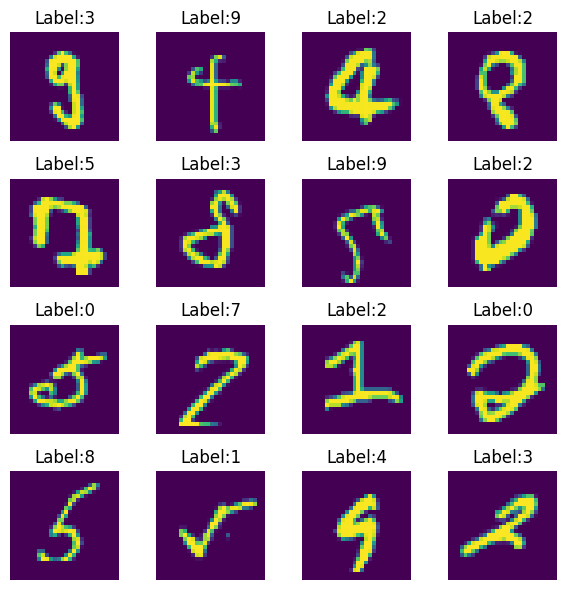

In [65]:
incorrect_idx = (valid_predict_y != split_valid_y)
incorrect_images = split_valid_x[:,incorrect_idx[0,:]]
incorrect_labels = valid_predict_y[:,incorrect_idx[0,:]]
print_images(incorrect_images, (28,28), 4, 4, incorrect_labels)

In [66]:
W1 = softmax_params["W1"]
b1 = softmax_params["b1"]
W2 = softmax_params["W2"]
b2 = softmax_params["b2"]

print("W1.shape:" + str(W1.shape))
print("b1.shape:" + str(b1.shape))
print("W2.shape:" + str(W2.shape))
print("b2.shape:" + str(b2.shape))

W1.shape:(64, 784)
b1.shape:(64, 1)
W2.shape:(10, 64)
b2.shape:(10, 1)


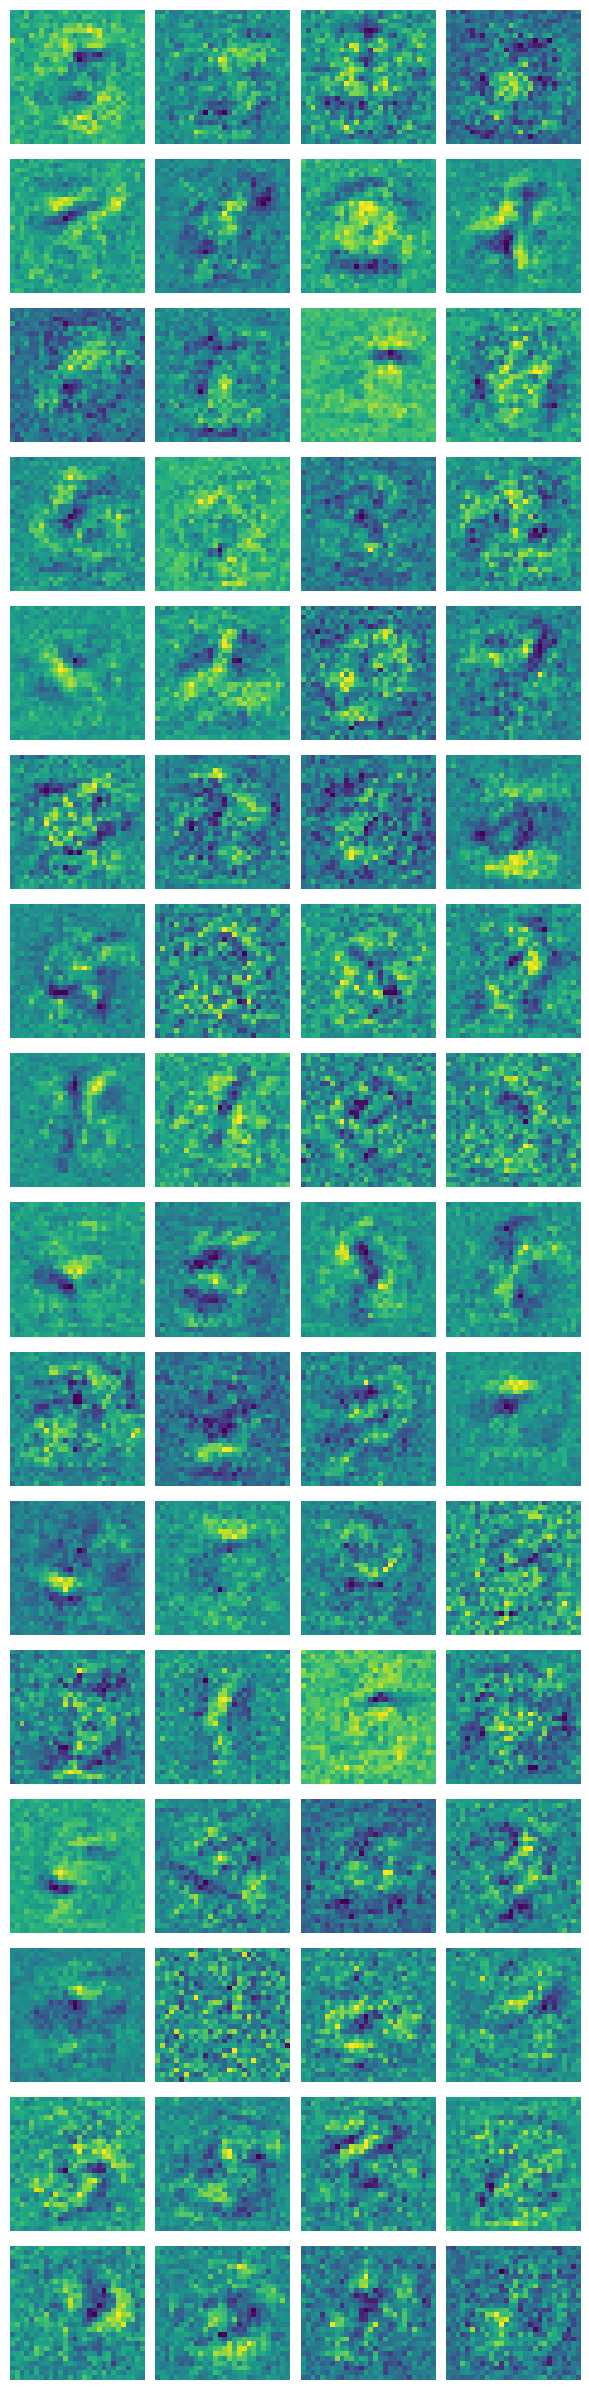

In [68]:
print_layer(W1.T, (28, 28), 16, 4)